In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

30
1


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 5))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 5))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),5))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05625  0.056875 0.0575   0.058125 0.05875  0.059375 0.06     0.060625
 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375 0.065    0.065625
 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375 0.07     0.070625
 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


<function matplotlib.pyplot.show(close=None, block=None)>

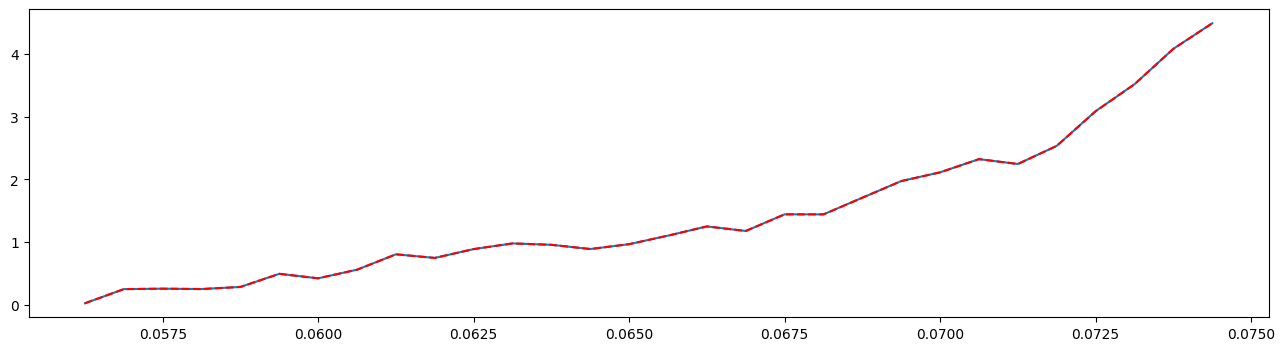

In [5]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)
v_train[:,:,:,3:5]=v_train_dot[:,:,:,0:2]
vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.9957774001416696 0.9997569597878921
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9991837746583707 0.9999779054352629
SI(average/percent):
0.9999497164065217 1.0


(0.9999497164065217, 1.0)

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x*x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x , y , z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x+x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x , y , z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)




print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t','ax','ay'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()'''

SINDy
(Vx)' = 1.000 ax
(Vy)' = 1.000 ay
(t)' = 1.000 1
(ax)' = 0.000
(ay)' = 0.000


C:\Users\j\miniconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


"\nprint('STLSQ model: ')\noptimizer = ps.STLSQ(threshold=50, alpha=1e-5, \n                     normalize_columns=True, max_iter=200)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])\nmodel.fit(v_train, dt_train)\nmodel.print()"

In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -4.085106
Model score: -13.296590
Model score: 0.468880
Model score: 0.498376


In [9]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [10]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 5))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),5))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]

v_test_dot = ps.FiniteDifference(axis=2)._differentiate(v_test, dt_train)
v_test[:,:,:,3:5]=v_test_dot[:,:,:,0:2]

In [11]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,5)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [12]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])


add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.9557422457639905 0.9823685373398144
SI(average/percent):
0.9951948813708948 1.0


(0.9951948813708948, 1.0)

0
MI(average/percent):
0.9576396857385286 0.9838709677419355
SI(average/percent):
0.9952581640986122 1.0


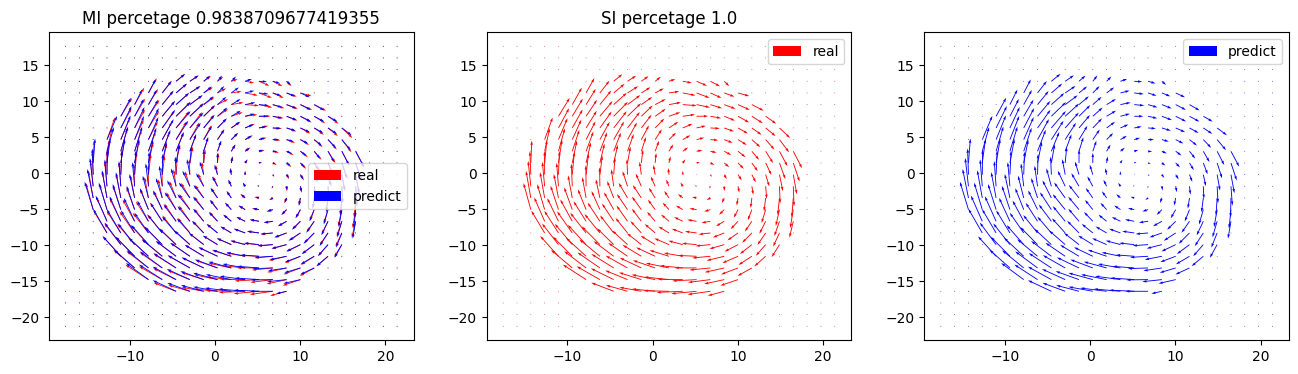

1
MI(average/percent):
0.9574425873671543 0.9838709677419355
SI(average/percent):
0.9951315986431768 1.0
2
MI(average/percent):
0.957262614495078 0.9838709677419355
SI(average/percent):
0.9949762022294972 1.0
3
MI(average/percent):
0.9570952029218925 0.9806451612903225
SI(average/percent):
0.9947909880947189 1.0
4
MI(average/percent):
0.9569394241321825 0.9806451612903225
SI(average/percent):
0.9945742409705097 1.0
5
MI(average/percent):
0.9567961067595545 0.9806451612903225
SI(average/percent):
0.9943228070467354 1.0


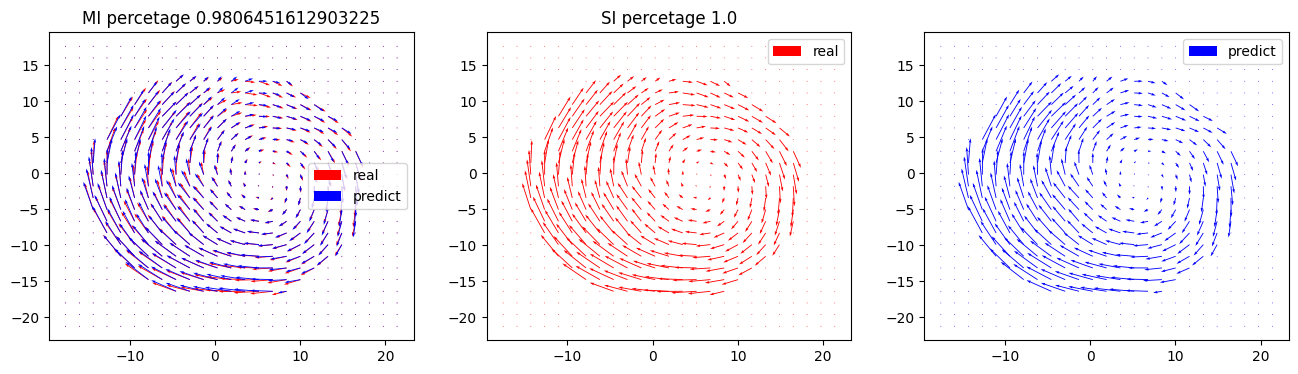

6
MI(average/percent):
0.9560098123009271 0.9774193548387097
SI(average/percent):
0.9939144887063706 1.0
7
MI(average/percent):
0.9561742445204032 0.9774193548387097
SI(average/percent):
0.993935245248656 1.0
8
MI(average/percent):
0.9562537890489745 0.9838709677419355
SI(average/percent):
0.9938175173148674 0.9967741935483871
9
MI(average/percent):
0.9561763569727603 0.9774193548387097
SI(average/percent):
0.9934478426791208 0.9967741935483871
10
MI(average/percent):
0.9556108573347191 0.9774193548387097
SI(average/percent):
0.9924102043985868 0.9967741935483871


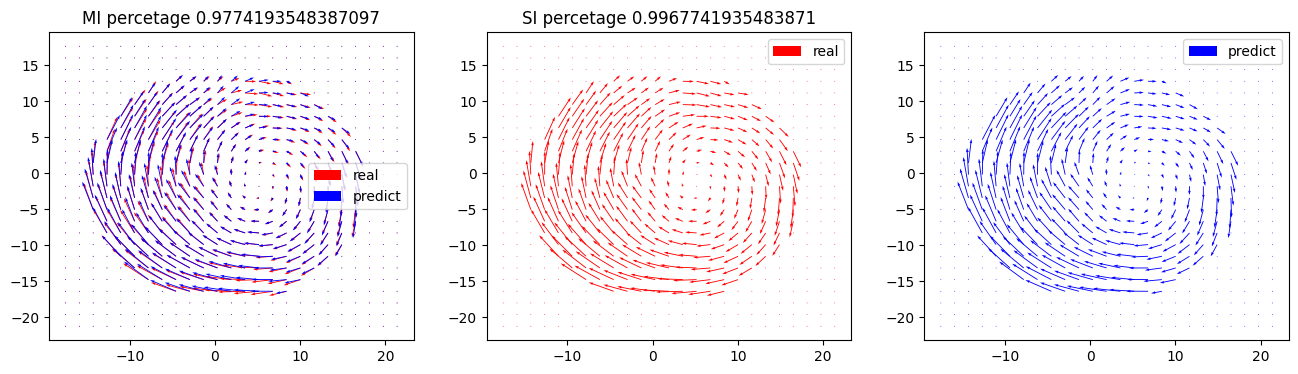

11
MI(average/percent):
0.9547125805772576 0.9774193548387097
SI(average/percent):
0.9930468273849711 0.9967741935483871
12
MI(average/percent):
0.9541795912880106 0.9774193548387097
SI(average/percent):
0.9931986329423845 0.9967741935483871
13
MI(average/percent):
0.9543988906652109 0.9774193548387097
SI(average/percent):
0.9912670257772266 0.9967741935483871
14
MI(average/percent):
0.9543228123994923 0.9741935483870968
SI(average/percent):
0.9920248548304614 0.9967741935483871
15
MI(average/percent):
0.9540071295367566 0.9709677419354839
SI(average/percent):
0.992457398320001 0.9967741935483871


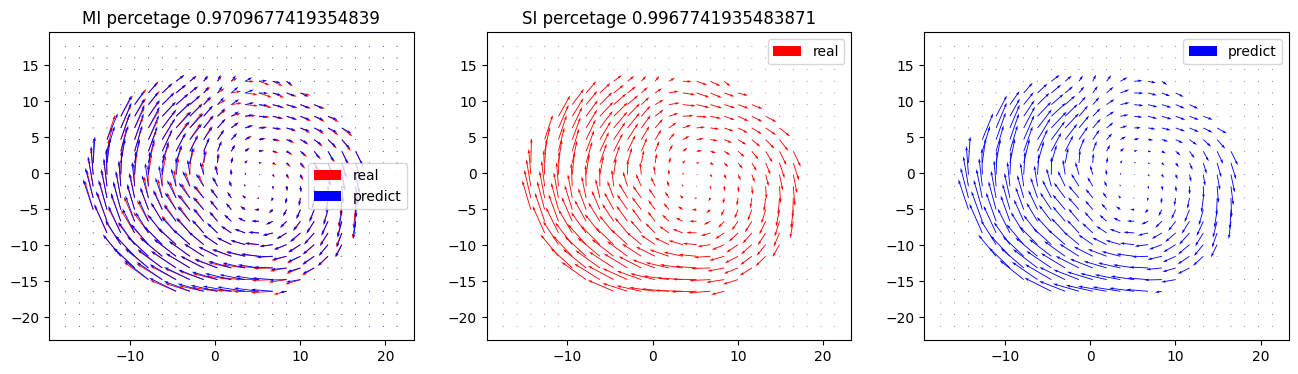

16
MI(average/percent):
0.9529439326360737 0.9741935483870968
SI(average/percent):
0.9922633090070172 0.9967741935483871
17
MI(average/percent):
0.9528456900873945 0.9709677419354839
SI(average/percent):
0.9917897301618788 0.9967741935483871
18
MI(average/percent):
0.9527019331026295 0.9741935483870968
SI(average/percent):
0.9911352319993922 0.9967741935483871
19
MI(average/percent):
0.9525008870585897 0.9709677419354839
SI(average/percent):
0.9912977864662345 0.9967741935483871
20
MI(average/percent):
0.9522473444313093 0.9709677419354839
SI(average/percent):
0.9921240945087954 0.9967741935483871


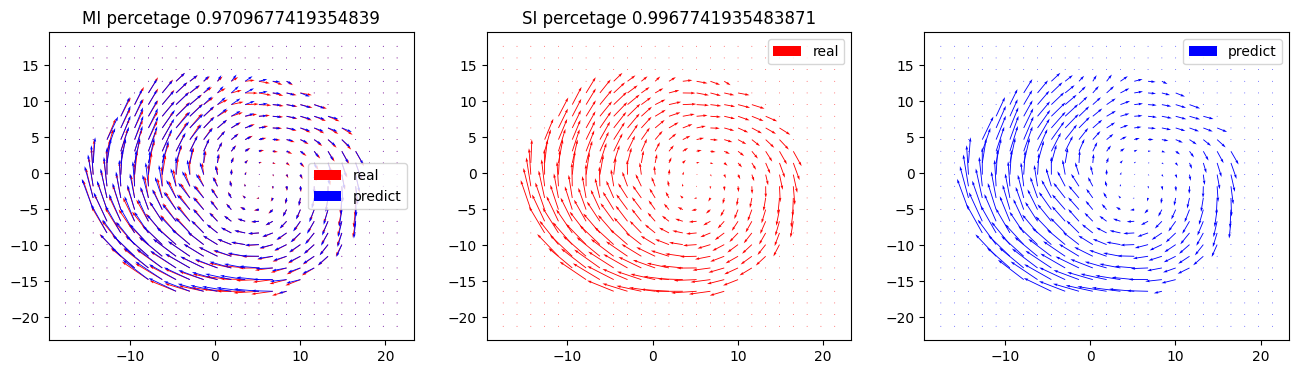

21
MI(average/percent):
0.9524158706063504 0.9612903225806452
SI(average/percent):
0.9920997281411238 0.9967741935483871
22
MI(average/percent):
0.9525147071607449 0.964516129032258
SI(average/percent):
0.9924827727910377 0.9967741935483871
23
MI(average/percent):
0.9526635516735225 0.967741935483871
SI(average/percent):
0.9926826981783478 1.0
24
MI(average/percent):
0.9528426512039667 0.967741935483871
SI(average/percent):
0.9927525846516978 1.0
25
MI(average/percent):
0.9525008355943595 0.967741935483871
SI(average/percent):
0.9927220324660915 1.0


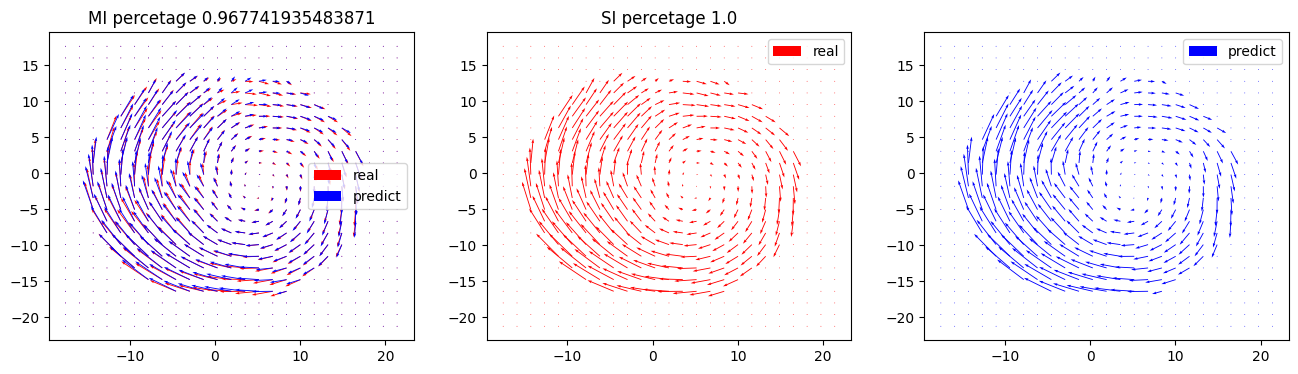

26
MI(average/percent):
0.9516595031053687 0.964516129032258
SI(average/percent):
0.9925715950671152 0.9967741935483871
27
MI(average/percent):
0.9521260973827332 0.967741935483871
SI(average/percent):
0.9922246590878269 0.9967741935483871
28
MI(average/percent):
0.9525386537510494 0.967741935483871
SI(average/percent):
0.9917801311434818 0.9967741935483871
29
MI(average/percent):
0.9528237845435547 0.9741935483870968
SI(average/percent):
0.9913561081847699 0.9967741935483871
30
MI(average/percent):
0.953075472500355 0.9741935483870968
SI(average/percent):
0.9917519043759923 0.9967741935483871


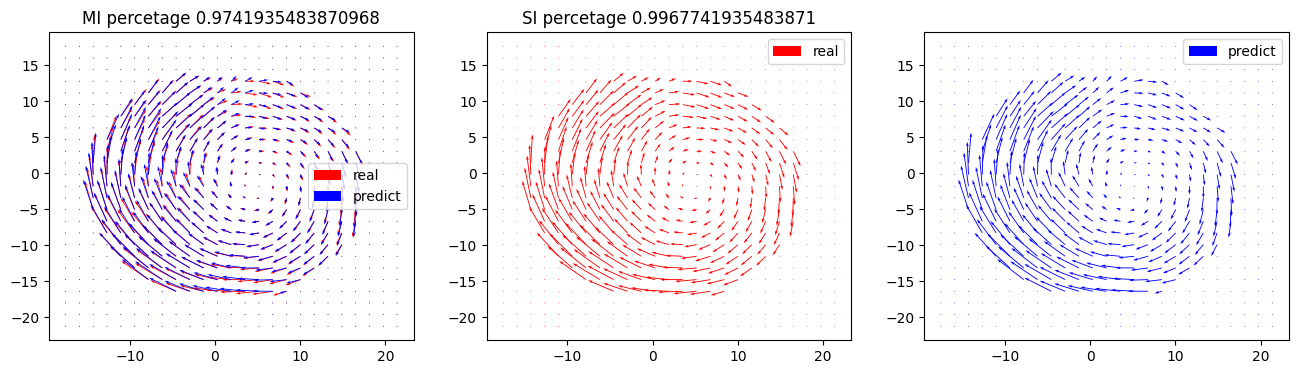

31
MI(average/percent):
0.9534609971862861 0.9774193548387097
SI(average/percent):
0.9925964768480995 0.9967741935483871
32
MI(average/percent):
0.9533415022336723 0.9774193548387097
SI(average/percent):
0.9933713086201342 0.9967741935483871
33
MI(average/percent):
0.9532557484847525 0.9774193548387097
SI(average/percent):
0.9939197699377925 0.9967741935483871
34
MI(average/percent):
0.9531873644662617 0.9774193548387097
SI(average/percent):
0.994317860767703 0.9967741935483871
35
MI(average/percent):
0.9531294378726515 0.9806451612903225
SI(average/percent):
0.9946127086592509 0.9967741935483871


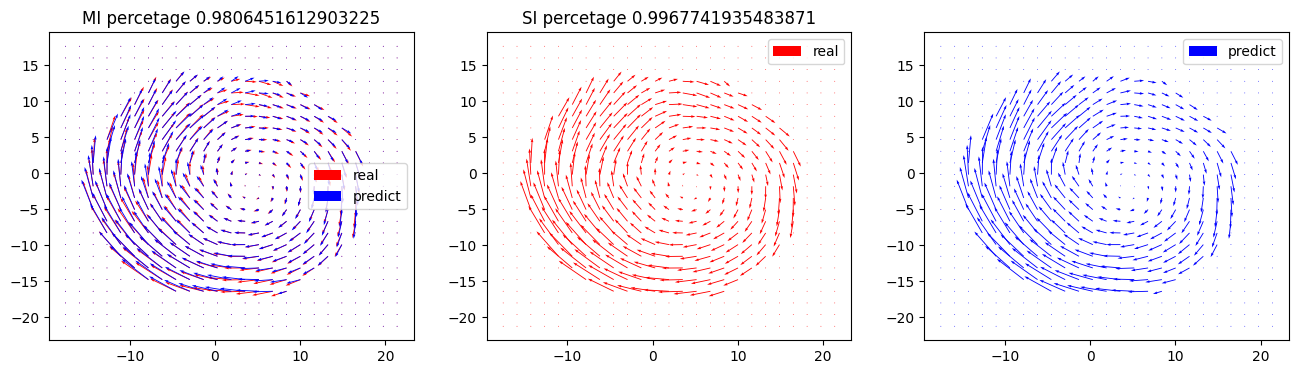

36
MI(average/percent):
0.9536319825893786 0.9838709677419355
SI(average/percent):
0.9946754728477887 1.0
37
MI(average/percent):
0.9534110385385879 0.9838709677419355
SI(average/percent):
0.994695366936482 1.0
38
MI(average/percent):
0.9530292651247423 0.9806451612903225
SI(average/percent):
0.9936504578537577 0.9967741935483871
39
MI(average/percent):
0.9517625336606639 0.9806451612903225
SI(average/percent):
0.9932553412789481 0.9967741935483871
40
MI(average/percent):
0.9529559312545174 0.9838709677419355
SI(average/percent):
0.9947258242031374 1.0


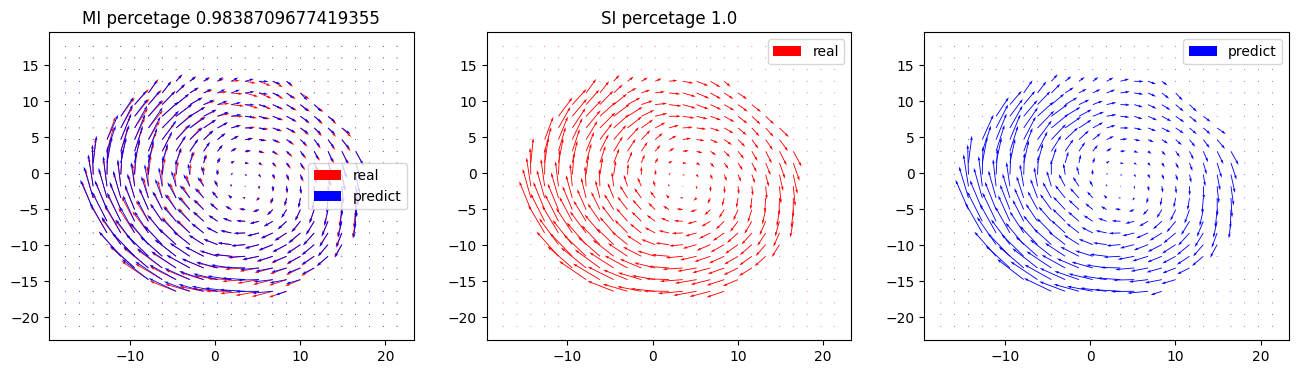

41
MI(average/percent):
0.9534490961037124 0.9838709677419355
SI(average/percent):
0.9952527713762844 1.0
42
MI(average/percent):
0.9537650289229369 0.9838709677419355
SI(average/percent):
0.9951162874666712 1.0
43
MI(average/percent):
0.9540417215962371 0.9870967741935484
SI(average/percent):
0.9949103778202865 1.0
44
MI(average/percent):
0.9543528903119377 0.9903225806451613
SI(average/percent):
0.9946475661490963 1.0
45
MI(average/percent):
0.9546739837022898 0.9935483870967742
SI(average/percent):
0.9943503170129447 1.0


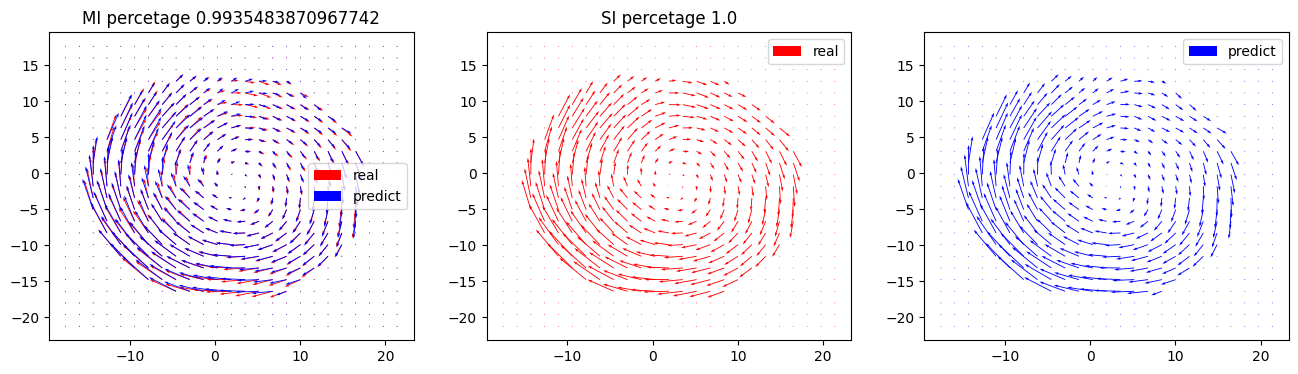

46
MI(average/percent):
0.9541985575670433 0.9870967741935484
SI(average/percent):
0.993582435488701 1.0
47
MI(average/percent):
0.9544992169516132 0.9935483870967742
SI(average/percent):
0.9935986384947344 1.0
48
MI(average/percent):
0.9547859316082447 0.9935483870967742
SI(average/percent):
0.993647529791355 1.0
49
MI(average/percent):
0.9551042735120989 0.9903225806451613
SI(average/percent):
0.9937289735989356 1.0
50
MI(average/percent):
0.9554762589598681 0.9903225806451613
SI(average/percent):
0.9937974906887922 1.0


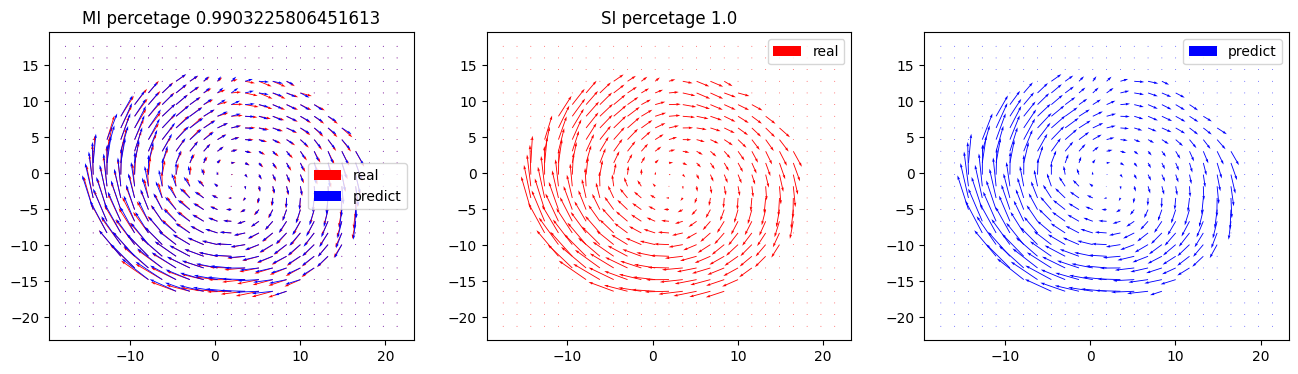

51
MI(average/percent):
0.955463831700831 0.9903225806451613
SI(average/percent):
0.9938243764240028 1.0
52
MI(average/percent):
0.955501814484646 0.9935483870967742
SI(average/percent):
0.9937298338015028 1.0
53
MI(average/percent):
0.9554359287876107 0.9935483870967742
SI(average/percent):
0.9936125791697934 1.0
54
MI(average/percent):
0.9552957769841701 0.9935483870967742
SI(average/percent):
0.993442090782391 0.9967741935483871
55
MI(average/percent):
0.9551130223113881 0.9870967741935484
SI(average/percent):
0.9931518514390173 0.9967741935483871


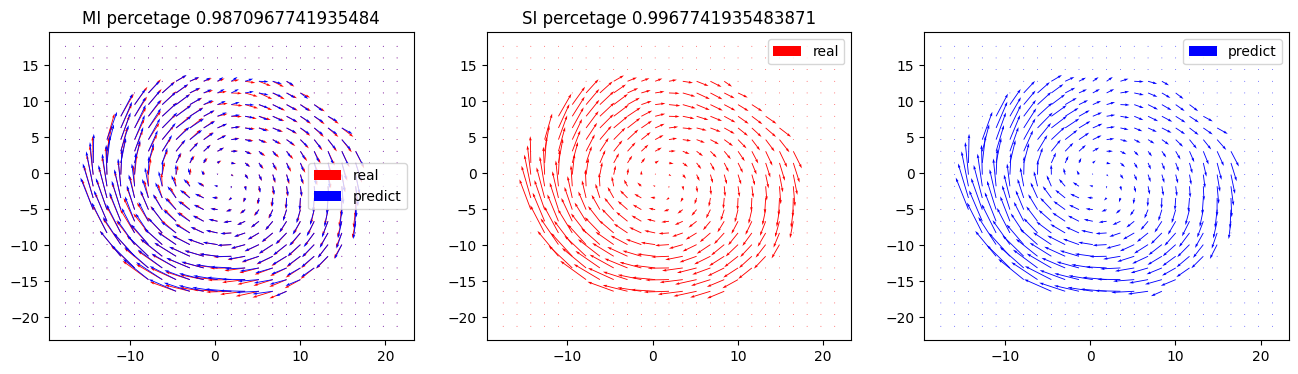

56
MI(average/percent):
0.9558699171183167 0.9870967741935484
SI(average/percent):
0.9924516080905513 0.9967741935483871
57
MI(average/percent):
0.9556918772401695 0.9870967741935484
SI(average/percent):
0.9917232660568671 0.9967741935483871
58
MI(average/percent):
0.9552951828162466 0.9838709677419355
SI(average/percent):
0.9906794920541557 0.9967741935483871
59
MI(average/percent):
0.9546683960438831 0.9838709677419355
SI(average/percent):
0.9915481877146152 0.9935483870967742
60
MI(average/percent):
0.9537694156409686 0.9838709677419355
SI(average/percent):
0.9927496855262145 0.9967741935483871


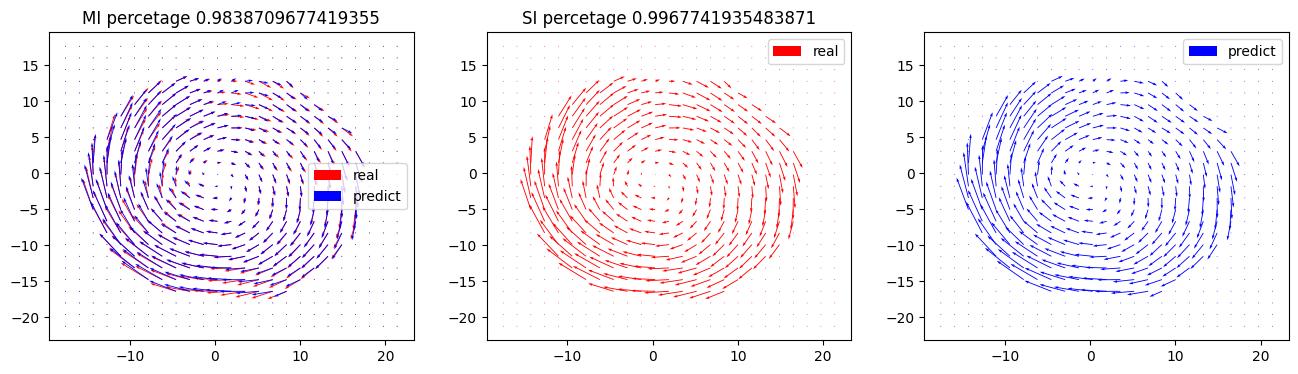

61
MI(average/percent):
0.9513930314540847 0.9838709677419355
SI(average/percent):
0.9926169224805299 0.9967741935483871
62
MI(average/percent):
0.9515690841729804 0.9806451612903225
SI(average/percent):
0.9904476776403929 0.9935483870967742
63
MI(average/percent):
0.9518049659896263 0.9806451612903225
SI(average/percent):
0.9913994331395548 0.9935483870967742
64
MI(average/percent):
0.9519043698579535 0.9806451612903225
SI(average/percent):
0.991452066824217 0.9935483870967742
65
MI(average/percent):
0.9519224417655425 0.9774193548387097
SI(average/percent):
0.9914242768916265 0.9935483870967742


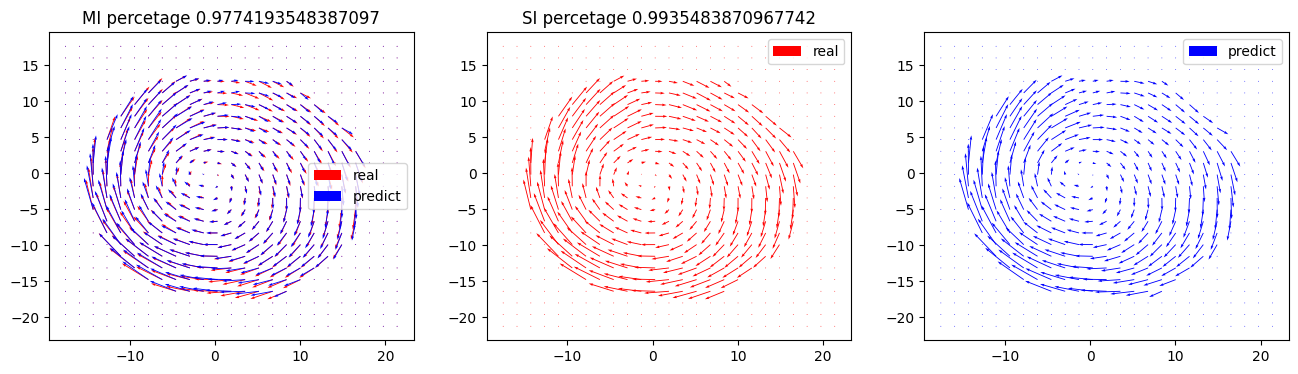

66
MI(average/percent):
0.9528713262377756 0.9838709677419355
SI(average/percent):
0.9937695570111138 0.9935483870967742
67
MI(average/percent):
0.9531842126839633 0.9806451612903225
SI(average/percent):
0.9943208092927517 0.9967741935483871
68
MI(average/percent):
0.953815565387765 0.9838709677419355
SI(average/percent):
0.9918243098458593 0.9935483870967742
69
MI(average/percent):
0.9542140610367886 0.9838709677419355
SI(average/percent):
0.9905587658507531 0.9935483870967742
70
MI(average/percent):
0.9543665830383528 0.9903225806451613
SI(average/percent):
0.990832889185381 0.9935483870967742


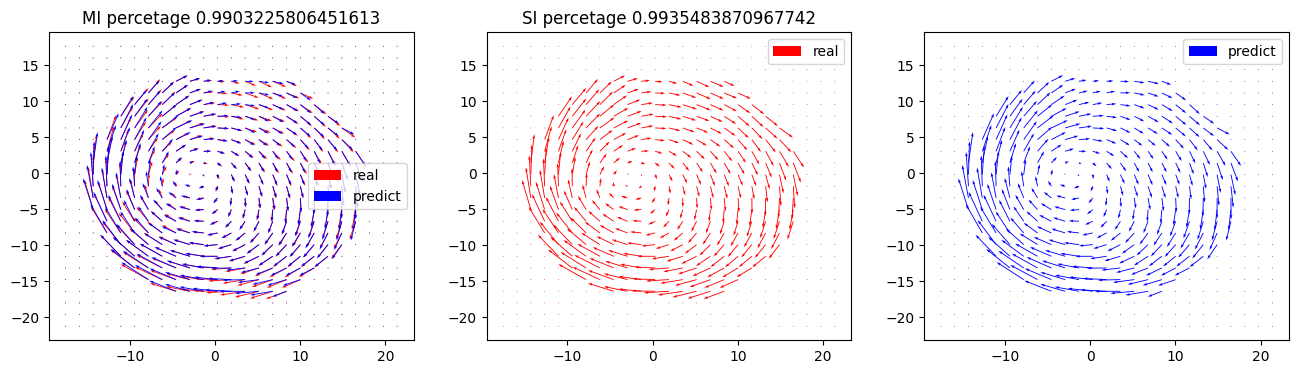

71
MI(average/percent):
0.9530807306712135 0.9870967741935484
SI(average/percent):
0.9923582538211836 0.9935483870967742
72
MI(average/percent):
0.9527302794349993 0.9838709677419355
SI(average/percent):
0.9937443165849101 0.9967741935483871
73
MI(average/percent):
0.9523971396092056 0.9838709677419355
SI(average/percent):
0.9941206133666283 0.9967741935483871
74
MI(average/percent):
0.9523255728350143 0.9838709677419355
SI(average/percent):
0.9930605097664372 0.9935483870967742
75
MI(average/percent):
0.9524308899037793 0.9838709677419355
SI(average/percent):
0.9916584167807817 0.9967741935483871


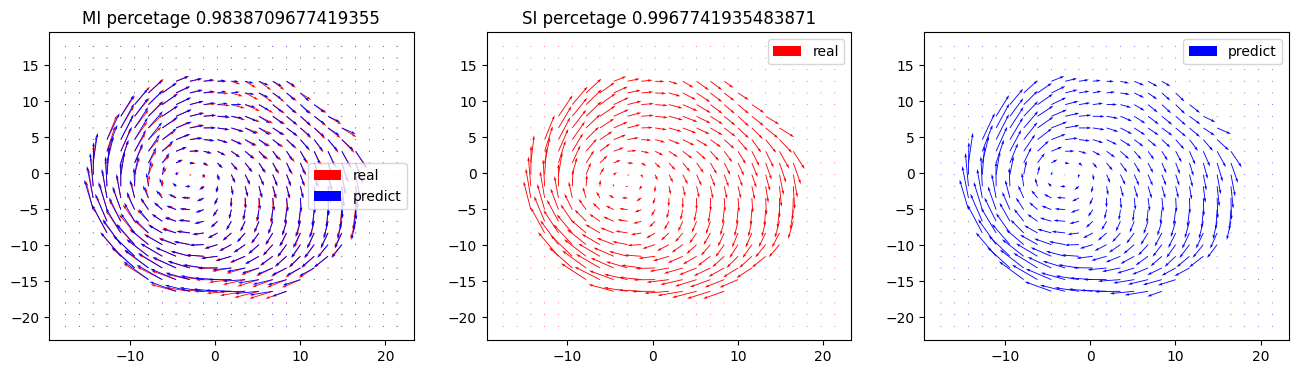

76
MI(average/percent):
0.9528427978223812 0.9838709677419355
SI(average/percent):
0.9917895845935434 0.9935483870967742
77
MI(average/percent):
0.9528957363486459 0.9838709677419355
SI(average/percent):
0.9925850068575532 0.9935483870967742
78
MI(average/percent):
0.9527461696797564 0.9774193548387097
SI(average/percent):
0.993155213720502 0.9935483870967742
79
MI(average/percent):
0.9524107888586182 0.9806451612903225
SI(average/percent):
0.9938268449359766 0.9935483870967742
80
MI(average/percent):
0.9522958621943916 0.9806451612903225
SI(average/percent):
0.9936269376814778 0.9967741935483871


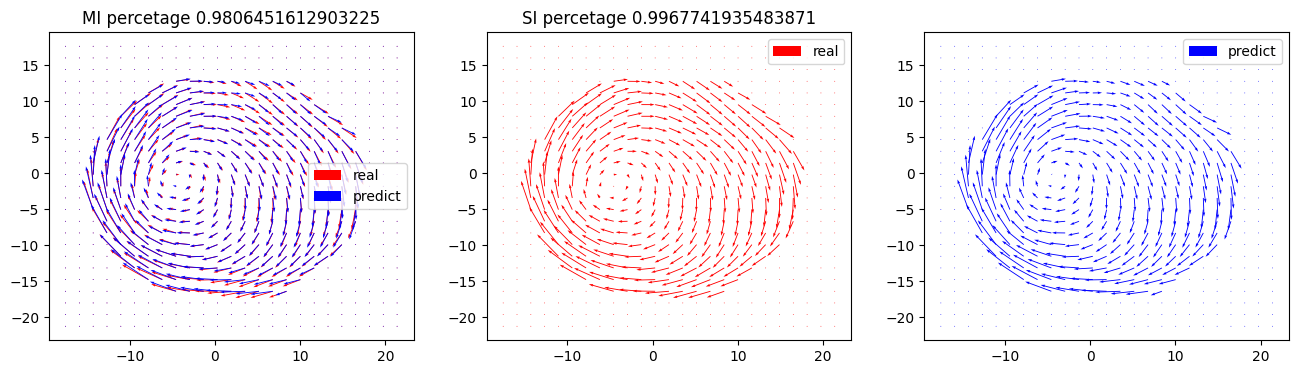

81
MI(average/percent):
0.9526538791120872 0.9774193548387097
SI(average/percent):
0.9926222617254252 0.9967741935483871
82
MI(average/percent):
0.9534611271618778 0.9806451612903225
SI(average/percent):
0.9921556791584122 0.9935483870967742
83
MI(average/percent):
0.9542405660147844 0.9774193548387097
SI(average/percent):
0.9919838132956691 0.9935483870967742
84
MI(average/percent):
0.9548801878931736 0.9774193548387097
SI(average/percent):
0.9918442101697187 0.9935483870967742
85
MI(average/percent):
0.955392024803421 0.9806451612903225
SI(average/percent):
0.9915900723003979 0.9935483870967742


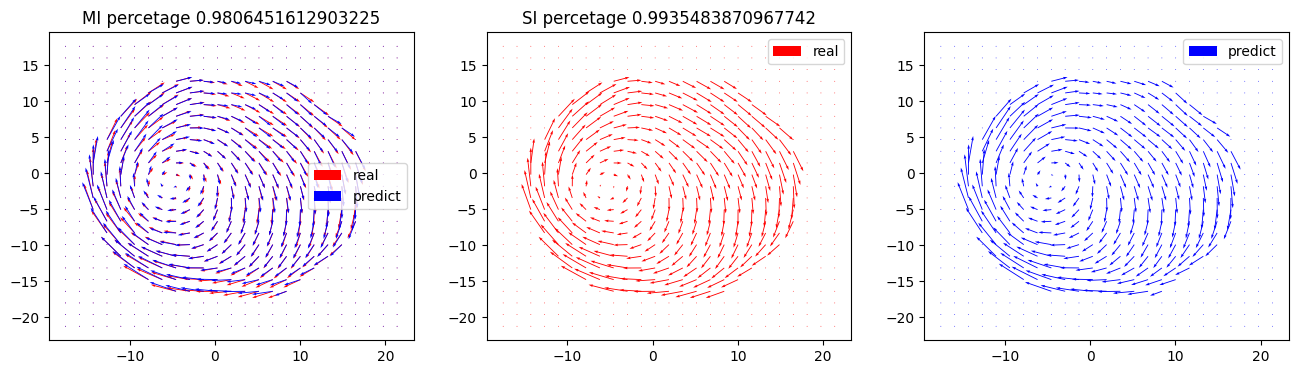

86
MI(average/percent):
0.9565717499416515 0.9838709677419355
SI(average/percent):
0.9907254473406526 0.9935483870967742
87
MI(average/percent):
0.9571996819004577 0.9870967741935484
SI(average/percent):
0.9904994040019944 0.9935483870967742
88
MI(average/percent):
0.9568430690873616 0.9870967741935484
SI(average/percent):
0.9910431430952823 0.9935483870967742
89
MI(average/percent):
0.956218767867632 0.9838709677419355
SI(average/percent):
0.9909070632222272 0.9935483870967742
90
MI(average/percent):
0.955999871942212 0.9838709677419355
SI(average/percent):
0.9905327058947446 0.9903225806451613


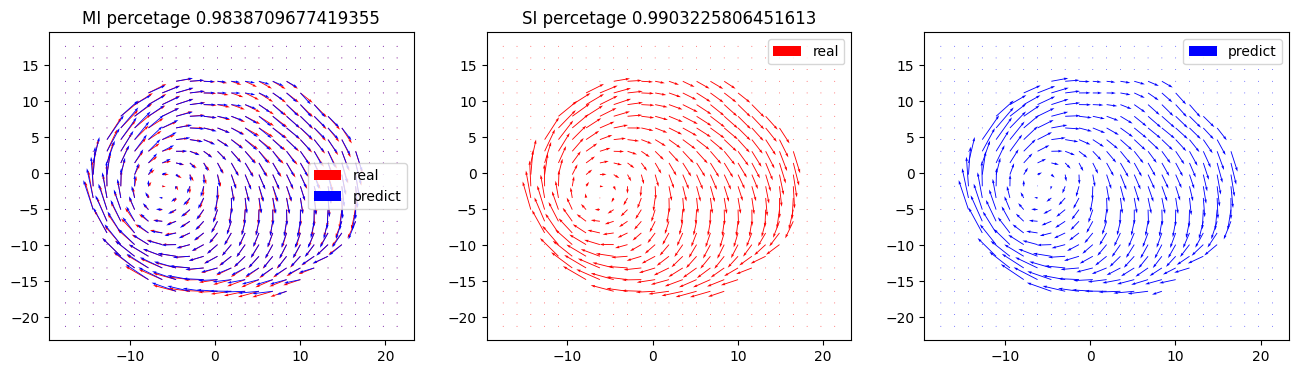

91
MI(average/percent):
0.9549647713866111 0.9838709677419355
SI(average/percent):
0.9906886793994129 0.9935483870967742
92
MI(average/percent):
0.9554128697645613 0.9870967741935484
SI(average/percent):
0.9907778115806369 0.9935483870967742
93
MI(average/percent):
0.9560105583376447 0.9838709677419355
SI(average/percent):
0.9912372646731973 0.9967741935483871
94
MI(average/percent):
0.9566333406628504 0.9870967741935484
SI(average/percent):
0.9917173292337522 0.9935483870967742
95
MI(average/percent):
0.9568866868102289 0.9870967741935484
SI(average/percent):
0.9921073898672007 0.9935483870967742


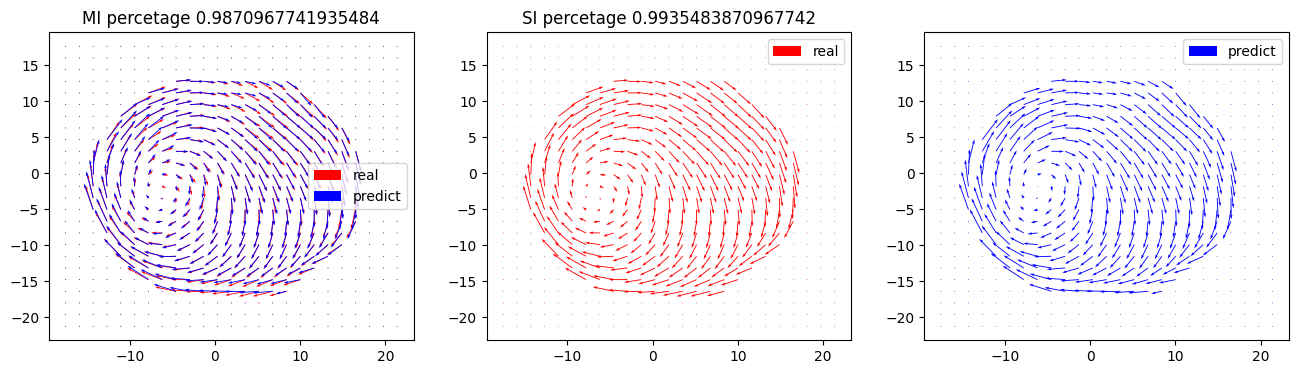

96
MI(average/percent):
0.9582793080126998 0.9903225806451613
SI(average/percent):
0.9927510516834203 0.9935483870967742
97
MI(average/percent):
0.9587592406017381 0.9870967741935484
SI(average/percent):
0.9929108706444569 0.9935483870967742
98
MI(average/percent):
0.9591950827308242 0.9870967741935484
SI(average/percent):
0.9928660462119961 0.9935483870967742
99
MI(average/percent):
0.959608232180889 0.9870967741935484
SI(average/percent):
0.9927227789121584 0.9903225806451613
100
MI(average/percent):
0.9596856778535786 0.9870967741935484
SI(average/percent):
0.9925137167400178 0.9935483870967742


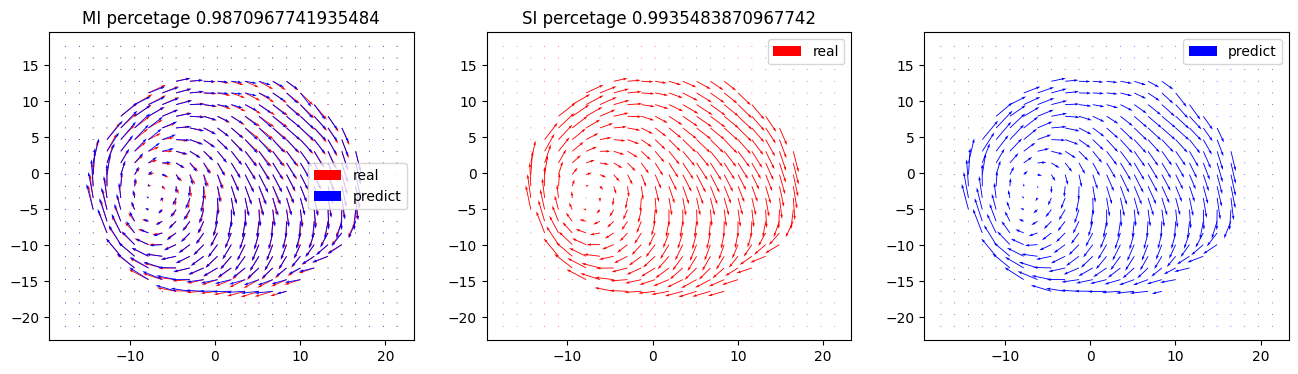

101
MI(average/percent):
0.9596972086086591 0.9870967741935484
SI(average/percent):
0.992086251217016 0.9935483870967742
102
MI(average/percent):
0.9598237002632802 0.9870967741935484
SI(average/percent):
0.992045781062076 0.9935483870967742
103
MI(average/percent):
0.959978063855276 0.9903225806451613
SI(average/percent):
0.9920659611110921 0.9935483870967742
104
MI(average/percent):
0.9601900760371332 0.9870967741935484
SI(average/percent):
0.9921615199464077 0.9935483870967742
105
MI(average/percent):
0.9604434128734166 0.9870967741935484
SI(average/percent):
0.9923223543968925 0.9935483870967742


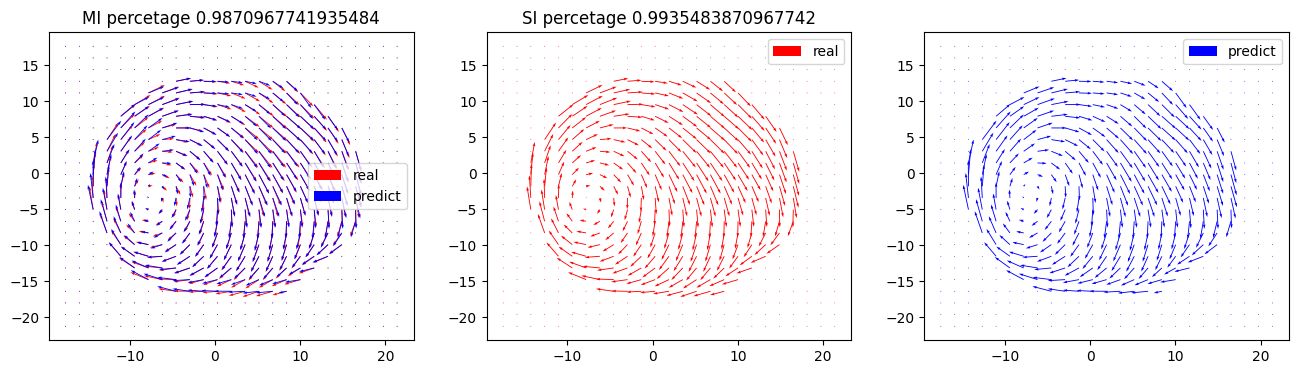

106
MI(average/percent):
0.961127628247376 0.9903225806451613
SI(average/percent):
0.9922235332284498 0.9935483870967742
107
MI(average/percent):
0.961800554692124 0.9903225806451613
SI(average/percent):
0.9926961025905983 0.9967741935483871
108
MI(average/percent):
0.9612689531177433 0.9870967741935484
SI(average/percent):
0.9924643464775953 0.9967741935483871
109
MI(average/percent):
0.9610124488610484 0.9870967741935484
SI(average/percent):
0.9926997878206418 0.9967741935483871
110
MI(average/percent):
0.9611834965436123 0.9838709677419355
SI(average/percent):
0.993823517146035 0.9935483870967742


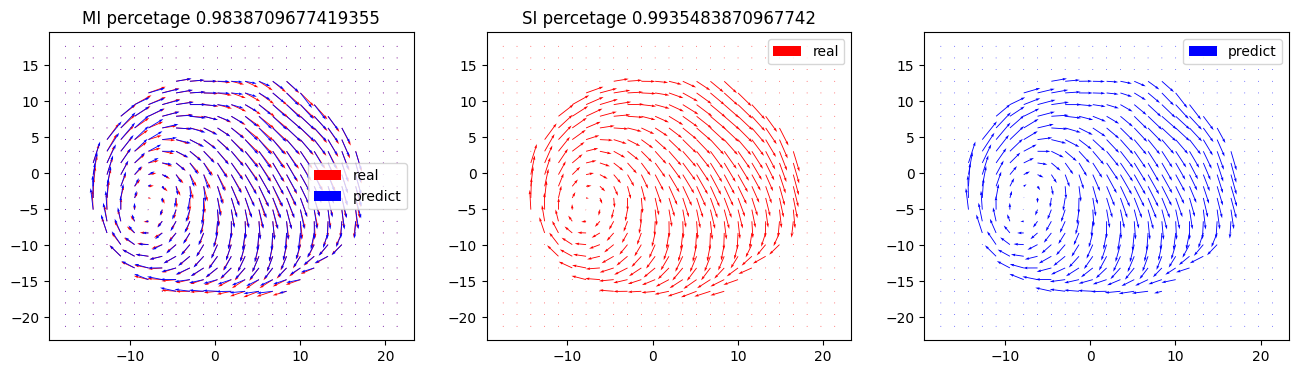

111
MI(average/percent):
0.960990281005243 0.9838709677419355
SI(average/percent):
0.9949452198437614 1.0
112
MI(average/percent):
0.9608420056693825 0.9838709677419355
SI(average/percent):
0.9953047422635497 1.0
113
MI(average/percent):
0.9607455661906652 0.9806451612903225
SI(average/percent):
0.995603615127396 1.0
114
MI(average/percent):
0.9606846264414117 0.9806451612903225
SI(average/percent):
0.9958140280448814 1.0
115
MI(average/percent):
0.9606707167431603 0.9806451612903225
SI(average/percent):
0.9959162029566913 1.0


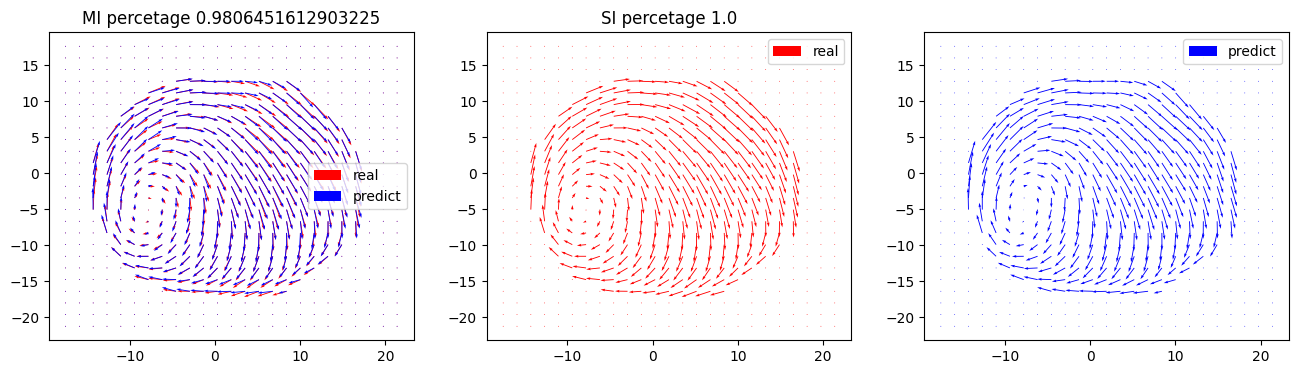

116
MI(average/percent):
0.9606370444225044 0.9838709677419355
SI(average/percent):
0.9957773275042459 1.0
117
MI(average/percent):
0.9610261375630389 0.9838709677419355
SI(average/percent):
0.9956785902977083 1.0
118
MI(average/percent):
0.9615339902619044 0.9935483870967742
SI(average/percent):
0.9954238743159742 0.9967741935483871
119
MI(average/percent):
0.9620444795278754 0.9935483870967742
SI(average/percent):
0.9952789348519727 0.9967741935483871
120
MI(average/percent):
0.9624675682672109 0.9935483870967742
SI(average/percent):
0.9953078055765749 0.9967741935483871


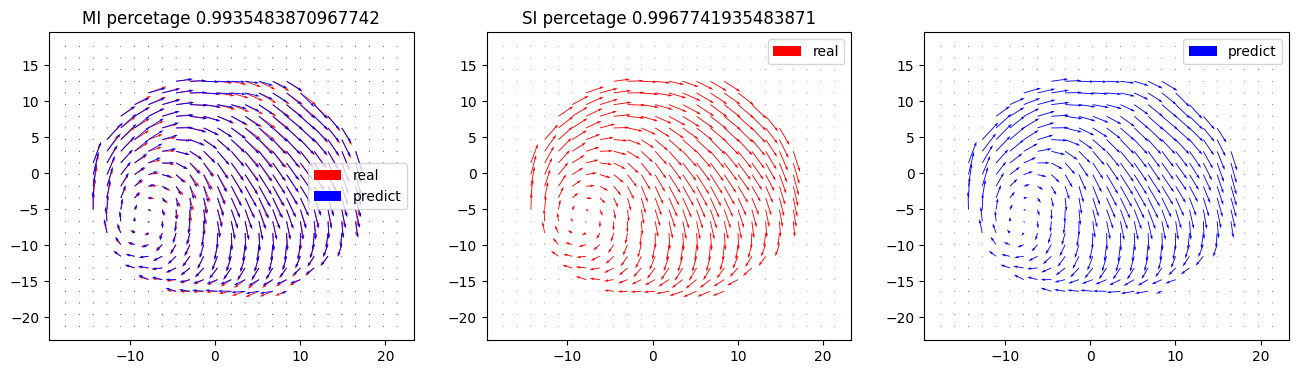

121
MI(average/percent):
0.9620682527325569 0.9967741935483871
SI(average/percent):
0.9950990606092509 0.9967741935483871
122
MI(average/percent):
0.9615048448106822 0.9935483870967742
SI(average/percent):
0.9949390571005985 0.9967741935483871
123
MI(average/percent):
0.9610043764440807 0.9935483870967742
SI(average/percent):
0.9948906037705793 0.9967741935483871
124
MI(average/percent):
0.9606803101448854 0.9935483870967742
SI(average/percent):
0.99481617438933 0.9967741935483871
125
MI(average/percent):
0.9605841270013279 0.9935483870967742
SI(average/percent):
0.9945506652796461 0.9967741935483871


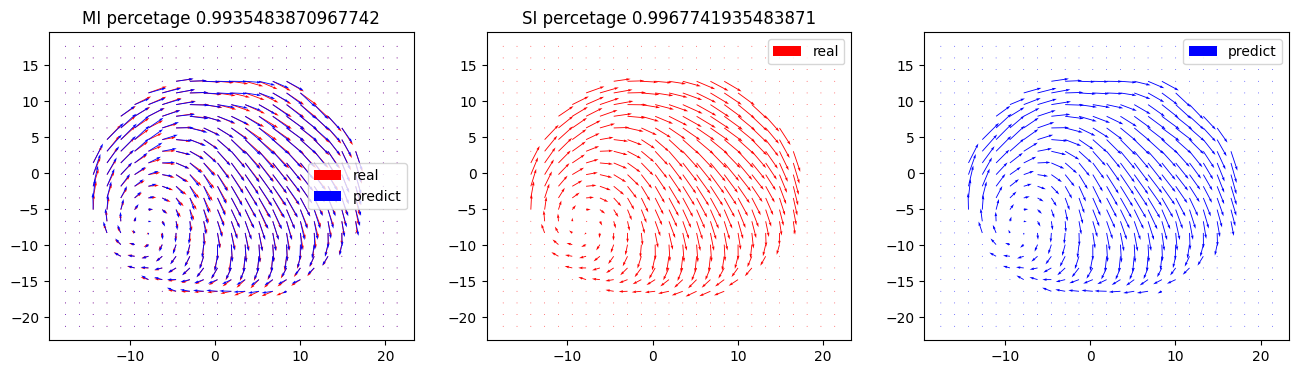

126
MI(average/percent):
0.9604358913419068 0.9935483870967742
SI(average/percent):
0.9943237865243354 0.9967741935483871
127
MI(average/percent):
0.9602375299218507 0.9967741935483871
SI(average/percent):
0.9943602964634052 0.9967741935483871
128
MI(average/percent):
0.9598603440375905 0.9935483870967742
SI(average/percent):
0.9945420357679384 0.9967741935483871
129
MI(average/percent):
0.9595633133324001 0.9935483870967742
SI(average/percent):
0.994720116256649 1.0
130
MI(average/percent):
0.9593422225161851 0.9903225806451613
SI(average/percent):
0.9948584279221364 1.0


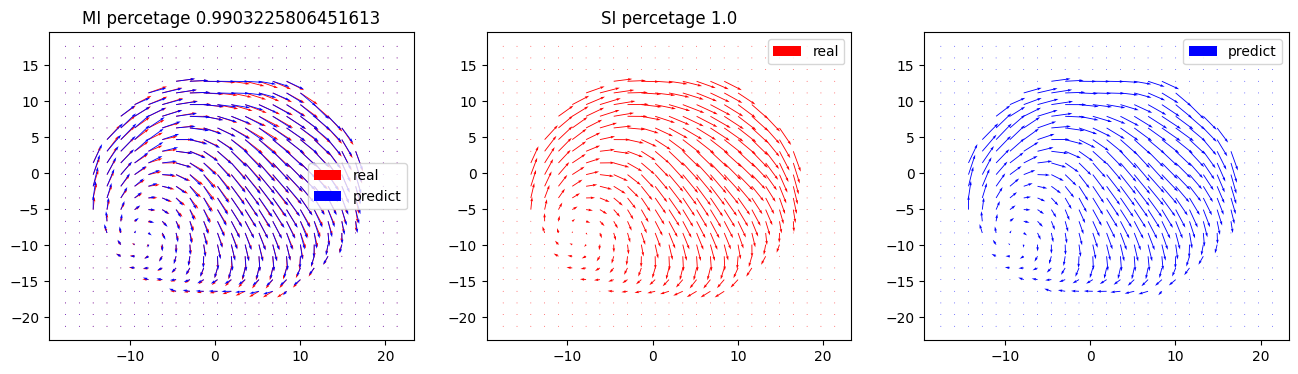

131
MI(average/percent):
0.9596282316557727 0.9870967741935484
SI(average/percent):
0.9945979336125975 1.0
132
MI(average/percent):
0.9588070826754543 0.9870967741935484
SI(average/percent):
0.9946246443912419 1.0
133
MI(average/percent):
0.9578944869433346 0.9870967741935484
SI(average/percent):
0.9947088726538738 1.0
134
MI(average/percent):
0.9569487810983774 0.9870967741935484
SI(average/percent):
0.9947442293143298 1.0
135
MI(average/percent):
0.9566307560217607 0.9870967741935484
SI(average/percent):
0.993732023662019 0.9967741935483871


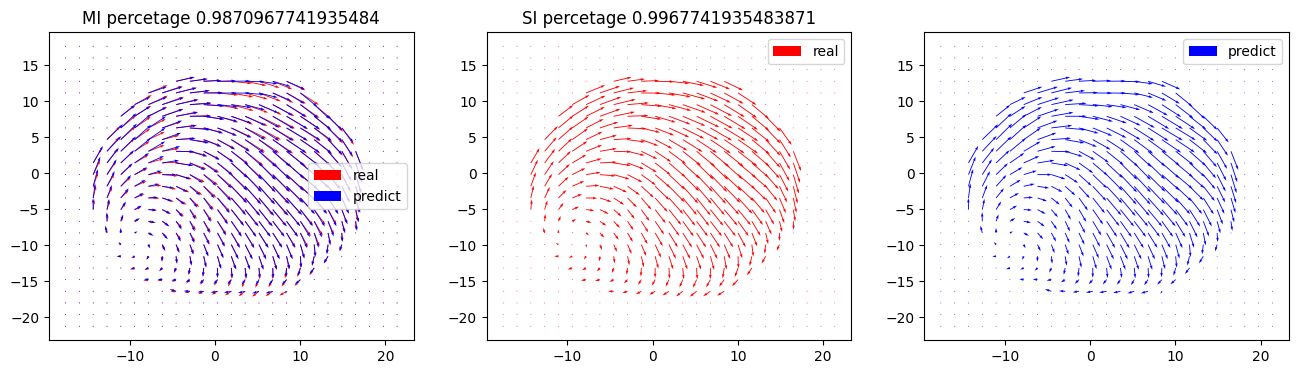

136
MI(average/percent):
0.9573798718156242 0.9935483870967742
SI(average/percent):
0.9921879567446001 0.9935483870967742
137
MI(average/percent):
0.956902739277895 0.9838709677419355
SI(average/percent):
0.9910930392150791 0.9935483870967742
138
MI(average/percent):
0.9554830454972335 0.9774193548387097
SI(average/percent):
0.991200768573275 0.9935483870967742
139
MI(average/percent):
0.9547025679016491 0.9806451612903225
SI(average/percent):
0.990351037208234 0.9967741935483871
140
MI(average/percent):
0.9541028606132559 0.9741935483870968
SI(average/percent):
0.9902167903283777 0.9935483870967742


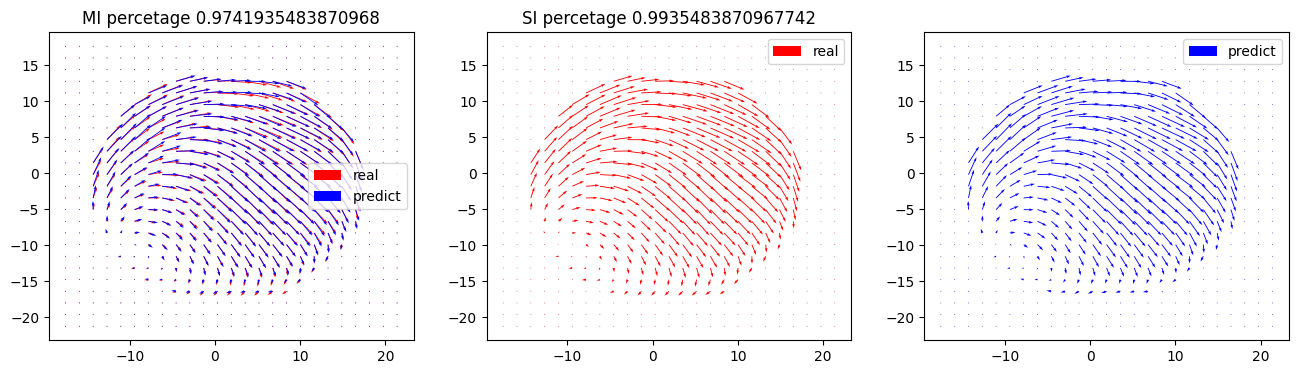

141
MI(average/percent):
0.9531437583769025 0.967741935483871
SI(average/percent):
0.990136934616703 0.9935483870967742
142
MI(average/percent):
0.9521955146653416 0.9612903225806452
SI(average/percent):
0.9896988706478449 0.9935483870967742
143
MI(average/percent):
0.9507485656190792 0.9516129032258065
SI(average/percent):
0.9888329777809863 0.9903225806451613
144
MI(average/percent):
0.9493094982361051 0.9483870967741935
SI(average/percent):
0.9890405818338623 0.9870967741935484
145
MI(average/percent):
0.9479021219475172 0.9516129032258065
SI(average/percent):
0.990098731095383 0.9870967741935484


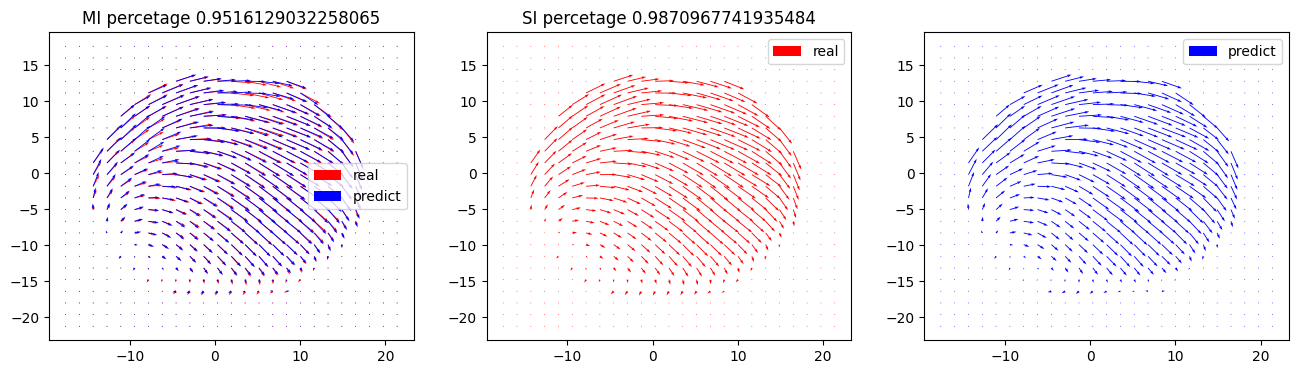

In [13]:
for i in range(p_tot):
    print(i)
    j=i
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('MI percetage '+str(mi_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('SI percetage '+str(si_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    

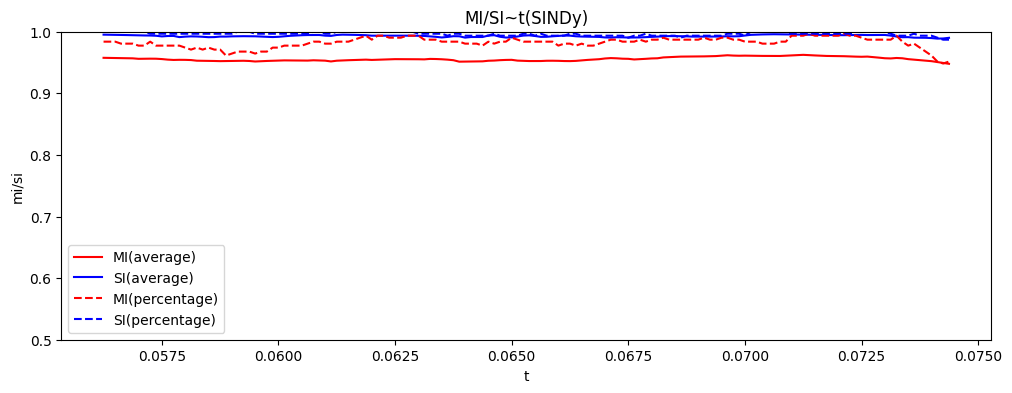

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.plot
plt.show()